In [6]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import random

In [7]:
AP_MS = nx.read_gml("AP_MS.gml")
Y2H = nx.read_gml("Y2H.gml")
LIT = nx.read_gml("LIT.gml")
LITR = nx.read_gml("LIT.gml")

Figura 2.b de He et. al. (2006) - Para cada una de las redes obtener α y β.



# Calculo alpha

ins forming anessential PPI must be essential (Figure 1A). On the contrary,
interactions between essential proteins (IBEPs) may or may not be essential.

We generated a control network by randomly rewiring all edges of the real network while keeping the node connectivity (k)
unchanged for every node. By repeating this procedure 10,000 times we obtained the distribution of the number (m) of IBEPs in randomly rewired networks (Figure 1B). 

## Recablear artistas y volver a ver calcular IBEPs

In [8]:
raw_m = 0
for n1,n2 in AP_MS.edges():
        if  AP_MS.node[n1]["esencial"] and AP_MS.node[n2]["esencial"]:
            raw_m += 1
ms = []
for _ in tqdm(range(100)):
    G = AP_MS.copy()
    G = nx.double_edge_swap(G,nswap=5000,max_tries=100000)
    m = 0
    for n1,n2 in G.edges():
        if  G.node[n1]["esencial"] and G.node[n2]["esencial"]:
            m += 1
    ms.append(m)
mean_m = np.mean(ms)
std_m = np.std(ms)    

In [11]:
print([mean_m,std_m])
print (raw_m   )

[2290.47, 22.753661243852605]
2847


The mean of m is 592.6. None of the 10,000 m values is greater than the number of IBEPs in the real network, strongly suggesting an excess of IBEPs in the real network (p , 0.0001). 


## Ver relacion de IBEPs calculadas vs la observada

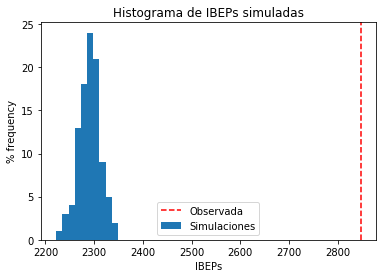

In [13]:
plt.hist(ms,label="Simulaciones")
plt.xlabel("IBEPs")
plt.ylabel("% frequency")
plt.title("Histograma de IBEPs simuladas")
plt.axvline(x=raw_m, color='red', linestyle='--',label="Observada")
plt.legend()
plt.show()

This excess is also evident in different datasets of yeast PPIs and in nematode PPIs  (see below and Figures S1 and S2). 
Under the assumption that the excess of IBEPs is entirely caused by essential PPIs, 
we estimate that a aplha = (807–592.6)/7356 
alpha = 2.92% of interactions in the yeast PPI network are essential. The standard error of a is 0.23%.

In [14]:
alpha = (raw_m - mean_m) / len(AP_MS.edges())
print( "alpha %f -> %.2f " % ( alpha, alpha * 100 ) + "%")

alpha 0.061359 -> 6.14 %


The standard error of a is 0.23% ????????????''

# Calculo Beta

In addition to essential PPIs, there are other factors (e.g., protein-DNA interaction) that could render a protein
essential. Let b be the probability that a node becomes essential by these other factors. To estimate b, we first remove
the information of gene essentiality in the yeast PPI network. e then randomly assign 807-m essential edges to this
network, where m is randomly drawn from its distribution n Figure 1B. Note that 807-m is the estimated number of
essential edges. Nodes having essential edges are marked ssential. Next, we mimic the influence of the other factors
that cause gene essentiality by randomly marking nodes as ssential, until the total number of essential nodes in the
network becomes 836. Repeating this procedure 10,000 times

In [15]:
n_esenciales = len([x for x,data in AP_MS.nodes(data=True) if data["esencial"] ])
n_esenciales

607

In [30]:
bs = []
overlaps = []
e_por_pii   = []
for _ in tqdm(range(100)):
    G = AP_MS.copy()
    # Cantidad de interacciones esenciales
    m =  random.choice(ms)
    EPII = raw_m - m
    # Asignar edges esenciales al azar y marcar nodos esenciales por estar en EPII
    nodos_esenciales = []
    for n1,n2 in random.sample(G.edges(),EPII):
        nodos_esenciales.append(n1)
        nodos_esenciales.append(n2)
    nodos_esenciales = set(nodos_esenciales)
    
    # Agregar nodos esenciales al azar hasta completar
    faltantes = n_esenciales - len(nodos_esenciales)
    e_por_pii.append(len(nodos_esenciales) )
    overlap = len(set(random.sample(G.nodes(), faltantes ) ) & nodos_esenciales)
    overlaps.append(overlap)
    agregados = set(random.sample(G.nodes(), faltantes ) ) - nodos_esenciales
    bs.append(len(agregados))
    
    
mean_b = np.mean(bs)
std_b = np.std(bs)
mean_o = np.mean(overlaps)
std_o = np.std(overlaps)
mean_pii = np.mean(e_por_pii)
std_pii = np.std(e_por_pii)




ValueError: Sample larger than population or is negative

In [17]:
print ([mean_b,std_b])

[21.0, 13.375350462698165]


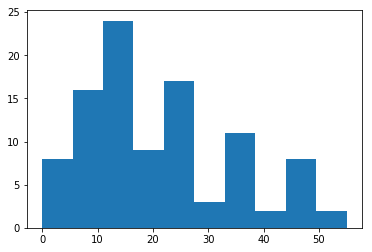

In [18]:
plt.hist(bs)
plt.show()

We estimate that the essential PPIs render 8.7% of nodes
essential, while the other factors render b 1⁄4 12.64% of nodes ssential. The standard error of b is 0.63%. Note that some nodes (1.1%) are affected by both essential PPIs and the other factors. Approximately 43% (8.7%/20.3%) of protein essentiality is attributable to essential interactions in the PPI network.

In [19]:
print("beta %.2f - overlap: %.2f - pii: %.2f" % (
    (mean_b / len(AP_MS.nodes())  ), 
    (mean_o * 1.0 / len(AP_MS.nodes())),
    (mean_pii * 1.0 / len(AP_MS.nodes()))
     )  )

beta 0.01 - overlap: 0.01 - pii: 0.35


The final and most critical evaluation of our estimates of a and b is to
test whether protein essentiality can be predicted using these
estimates. For a protein to be nonessential, two conditions
must be satisfied. First, the protein has no essential PPI.
Second, the protein is not affected by the other factors that
cause essentiality. Thus, the probability (P E ) that a protein
with k PPIs is essential is:

Pe = 1 -( 1 - b)(1 - alpha)^k  

where a and b have been estimated earlier. Thus, Pe values
can be predicted for each k using the above equation. Our observed P E from the yeast PPI network matched well to the predicted Pe

ln(1 - Pe ) = k ln(1 - alpha) + ln(1 - beta) 

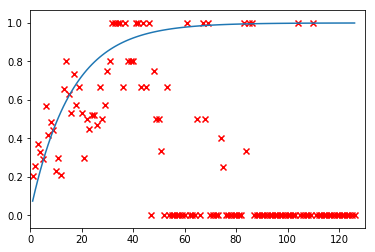

In [20]:
data = []

observed = []
max_k = max([x[1] for x in AP_MS.degree()])
beta = mean_b / len(AP_MS.nodes())
for k in range(1,max_k):
    data.append( 1 - (1 - beta) * (1 - alpha) ** k )
    nodos_de_grado_k = [x[0] for x in AP_MS.degree() if x[1] == k] 
    nodos_de_grado_k_esenciales = [x for x in nodos_de_grado_k if  AP_MS.node[x]["esencial"]]
    
    if nodos_de_grado_k:
        observed.append( len(nodos_de_grado_k_esenciales) /   len(nodos_de_grado_k) )
    else:
        observed.append(0)
    
plt.plot(range(1,max_k), data )
plt.scatter(range(1,max_k),observed,marker="x",c="red")
plt.xlim(0,130)
plt.show()

[-0.022956223359087397, -0.376252088821062]


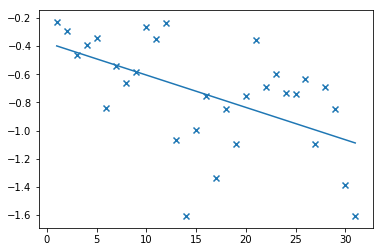

In [21]:
#ln(1 - Pe ) = k ln(1 - alpha) + ln(1 - beta) 
observed = []
for k in range(1,32):  # con mas  np.log(1 - pe ) da infinito
    nodos_de_grado_k = [x[0] for x in AP_MS.degree() if x[1] == k] 
    if nodos_de_grado_k:
        nodos_de_grado_k_esenciales = [x for x in nodos_de_grado_k if  AP_MS.node[x]["esencial"]]
        pe = len(nodos_de_grado_k_esenciales) /   len(nodos_de_grado_k)
        observed.append( [k,np.log(1 - pe )] )
#     else:
#         observed.append(0)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress([x[0] for x in observed],[x[1] for x in observed])
print([slope, intercept])
rect = []
for x in [x[0] for x in observed]:
    rect.append( intercept + slope * x)

plt.plot([x[0] for x in observed],rect)
plt.scatter([x[0] for x in observed],[x[1] for x in observed],marker="x")

plt.show()

In [22]:
#ln(1 - Pe ) = k ln(1 - alpha) + ln(1 - beta) 
alpha_ajustado = 1 - np.exp(slope  )  
beta_ajustado = 1 - np.exp(intercept  )  
print([alpha_ajustado,beta_ajustado])


[0.022694734021469598, 0.313570729915839]


In [23]:
def alpha_red(graph,nswap=1000,repes=10000,name="?"):
    ibeps = 0
    for n1,n2 in graph.edges():
            if  graph.node[n1]["esencial"] and graph.node[n2]["esencial"]:
                ibeps += 1
    ms = []
    for _ in tqdm(range(repes)):
        G = graph.copy()
        G = nx.double_edge_swap(G,nswap=nswap,max_tries=100000)
        m = 0
        for n1,n2 in G.edges():
            if  G.node[n1]["esencial"] and G.node[n2]["esencial"]:
                m += 1
        ms.append(m)
    mean_m = np.mean(ms)
    std_m = np.std(ms)
    
   
    
    plt.hist(ms,label="Simulaciones")
    plt.xlabel("IBEPs")
    plt.ylabel("% frequency")
    plt.title("Histograma de IBEPs simuladas en " + name)
    plt.axvline(x=ibeps, color='red', linestyle='--',label="Observada")
    plt.legend()
    plt.show()
    

    alpha = (ibeps - mean_m) / len(graph.edges())
    alpha_std = std_m / len(graph.edges())
    
    return alpha,alpha_std,ms,ibeps



In [24]:
def beta_red(graph,ms,repes=100):
    n_esenciales = len([x for x,data in graph.nodes(data=True) if data["esencial"] ])
    n_esenciales
    
    raw_m = 0
    for n1,n2 in graph.edges():
            if  graph.node[n1]["esencial"] and graph.node[n2]["esencial"]:
                raw_m += 1                
    bs = []
    overlaps = []
    e_por_pii   = []
    for _ in tqdm(range(repes)):
        G = graph.copy()
        # Cantidad de interacciones esenciales
        m =  random.choice(ms)
        EPII = raw_m - m
        # Asignar edges esenciales al azar y marcar nodos esenciales por estar en EPII
        nodos_esenciales = []
        for n1,n2 in random.sample(G.edges(),EPII):
            nodos_esenciales.append(n1)
            nodos_esenciales.append(n2)
        nodos_esenciales = set(nodos_esenciales)

        # Agregar nodos esenciales al azar hasta completar
        faltantes = n_esenciales - len(nodos_esenciales)  
        if faltantes < 0:
            faltantes = 0            
        e_por_pii.append(len(nodos_esenciales) )
       
        overlap = len(set(random.sample(G.nodes(), faltantes ) ) & nodos_esenciales)
        
        overlaps.append(overlap)
        agregados = set(random.sample(G.nodes(), faltantes ) ) - nodos_esenciales
        bs.append(len(agregados))

    mean_b = np.mean(bs)
    std_b = np.std(bs)
    mean_o = np.mean(overlaps)
    std_o = np.std(overlaps)
    mean_pii = np.mean(e_por_pii)
    std_pii = np.std(e_por_pii)
    
    #plt.hist(bs)
    #plt.show()
    beta = (mean_b / len(graph.nodes())  )
    beta_std = (std_b / len(graph.nodes())  )
    overlap = (std_b * 1.0 / len(graph.nodes()))
    pii = (mean_pii * 1.0 / len(graph.nodes()))
  
    return beta,beta_std,overlap,pii


In [25]:
def plot_alpha_beta(graph,alpha,beta,name):

    data = []

    observed = []
    max_k = max([x[1] for x in graph.degree()])
    for k in range(1,max_k):
        data.append( 1 - (1 - beta) * (1 - alpha) ** k )
        nodos_de_grado_k = [x[0] for x in graph.degree() if x[1] == k] 
        nodos_de_grado_k_esenciales = [x for x in nodos_de_grado_k if  graph.node[x]["esencial"]]

        if nodos_de_grado_k:
            observed.append( len(nodos_de_grado_k_esenciales) /   len(nodos_de_grado_k) )
        else:
            observed.append(0)

    plt.plot(range(1,max_k), data )
    plt.title(name + " Esencialidad predicha vs observada")
    plt.xlabel("Grado")
    plt.ylabel("Probabilidad de ser una proteina esencial")
    plt.scatter(range(1,max_k),observed,marker="x",c="red")
    plt.xlim(0,130)
    plt.show()
    
    

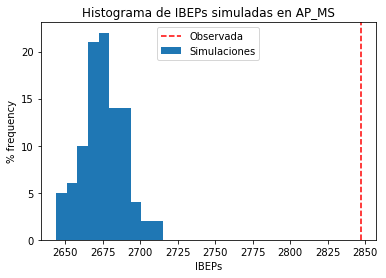

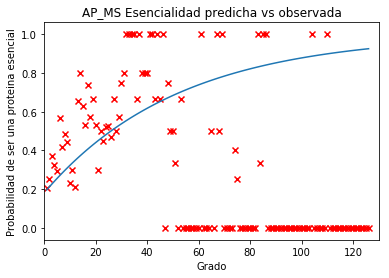

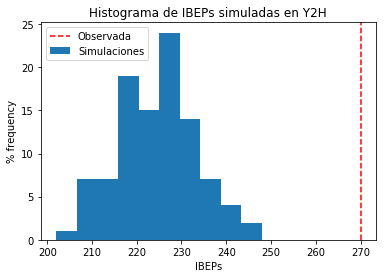

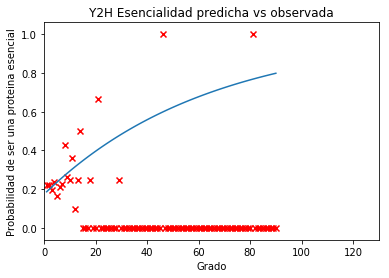

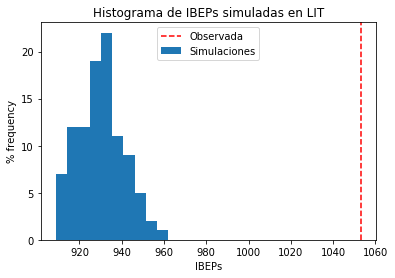

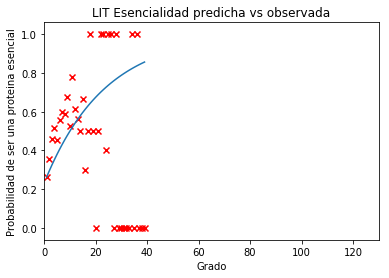

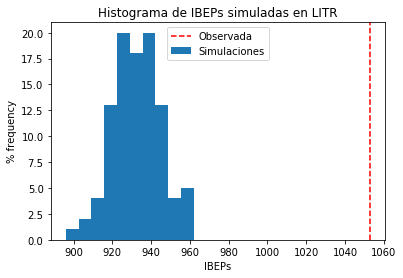

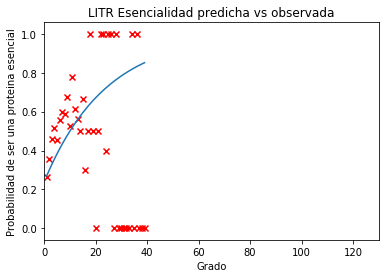

In [26]:
#Probar mas de un tamaño de nswap
tabla = []
for name,graph in {"AP_MS":AP_MS,"Y2H":Y2H,"LIT":LIT,"LITR":LITR}.items():
    alpha,alpha_std,ms,ibeps = alpha_red(graph,nswap=1000,repes=100,name=name)
    beta,beta_std,overlap,pii = beta_red(graph,ms,repes=100)
    plot_alpha_beta(graph,alpha,beta,name=name)
    tabla.append({"name":name,"alpha":alpha,"beta":beta,"overlap":overlap,"pii":pii,
                  "alpha_std":alpha_std,"beta_std":beta_std,"ibeps":ibeps })
    

In [36]:
pd.DataFrame(tabla)[[ "name", "alpha", "alpha_std","beta","beta_std","ibeps","overlap","pii"]]

,name,alpha,alpha_std,beta,beta_std,ibeps,overlap,pii
0,LIT,0.041217,0.003926,0.233874,0.233874,1053,0.014253,0.136152
1,AP_MS,0.018968,0.001422,0.179827,0.179827,2847,0.013523,0.160425
2,LITR,0.041019,0.004052,0.233945,0.233945,1053,0.013775,0.135423
3,Y2H,0.015051,0.002941,0.177468,0.177468,270,0.007751,0.039068


In [43]:
pd.DataFrame(tabla)[[ "name", "alpha", "alpha_std","beta","beta_std","ibeps","overlap","pii"]]

,name,alpha,alpha_std,beta,beta_std,ibeps,overlap,pii
0,LIT,0.041371,0.004229,0.233587,0.015800,1053,0.015800,0.136829
1,AP_MS,0.019049,0.001408,0.176313,0.010358,2847,0.010358,0.163527
2,LITR,0.041785,0.004174,0.234785,0.013443,1053,0.013443,0.135859
3,Y2H,0.015522,0.003307,0.176848,0.010441,270,0.010441,0.039564
